# **Lab7**

# **LSTM MODEL IMPLEMENTATION**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def augment_and_preprocess():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Flatten labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    datagen.fit(x_train)

    return x_train, y_train, x_test, y_test, datagen

In [ ]:
def get_seq_generator(x, y, datagen, batch_size=64, augment=False):
    while True:
        if augment:
            gen = datagen.flow(x, y, batch_size=batch_size, shuffle=True)
        else:
            gen = zip(
                [x[i:i+batch_size] for i in range(0, len(x), batch_size)],
                [y[i:i+batch_size] for i in range(0, len(y), batch_size)]
            )
        for batch_x, batch_y in gen:
            # reshape: (batch, 32, 32*3)
            batch_x = batch_x.reshape(-1, 32, 32*3)
            yield batch_x, tf.keras.utils.to_categorical(batch_y, num_classes=10)

In [ ]:
def build_lstm_model(input_shape=(32, 96), num_classes=10):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(64),
        Dropout(0.3),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
def train_model(model, train_gen, steps_per_epoch, x_val_seq, y_val, epochs=30):
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(x_val_seq, y_val)
    )
    return history

In [ ]:
def evaluate_model(model, history, x_test_seq, y_test, x_test_orig):
    y_pred = np.argmax(model.predict(x_test_seq), axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 105s 1us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 256)        │       361,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,858 (2.35 MB)

 Trainable params: 613,834 (2.34 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.2214 - loss: 2.2335 - val_accuracy: 0.3486 - val_loss: 1.7757
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.3385 - loss: 1.8066 - val_accuracy: 0.4168 - val_loss: 1.5834
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.3905 - loss: 1.6779 - val_accuracy: 0.3943 - val_loss: 1.6364
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.4207 - loss: 1.6081 - val_accuracy: 0.4446 - val_loss: 1.5272
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4484 - loss: 1.5337 - val_accuracy: 0.4882 - val_loss: 1.4110
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.4660 - loss: 1.4949 - val_accuracy: 0.5126 - val_loss: 1.3418
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4825 - loss: 1.4518 - val_accuracy: 0.4140 - val_loss: 1.6612
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.4980 - loss: 1.4151 - 

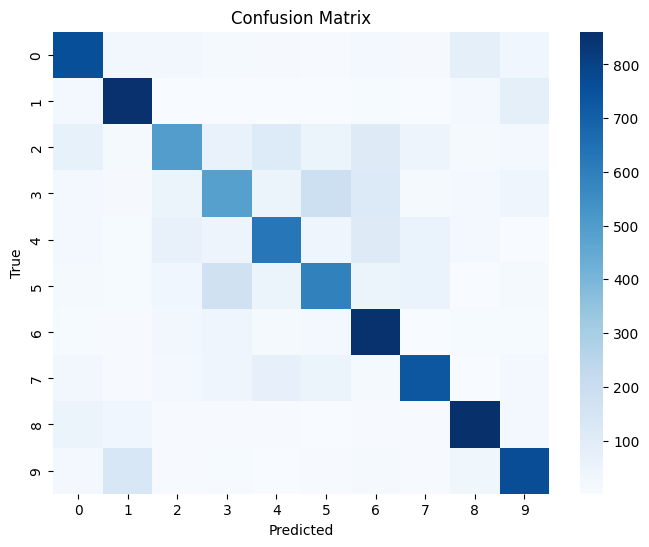


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1000
           1       0.77      0.86      0.81      1000
           2       0.67      0.50      0.57      1000
           3       0.55      0.49      0.51      1000
           4       0.66      0.63      0.64      1000
           5       0.62      0.59      0.61      1000
           6       0.65      0.85      0.74      1000
           7       0.78      0.73      0.76      1000
           8       0.81      0.86      0.83      1000
           9       0.76      0.76      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



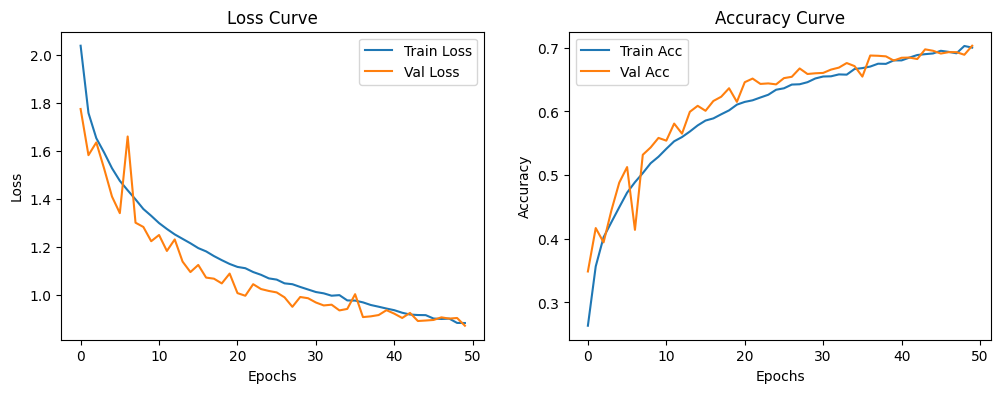

In [ ]:
def main():
    # Step 1
    x_train, y_train, x_test, y_test, datagen = augment_and_preprocess()

    # Step 2: Generators
    batch_size = 64
    train_gen = get_seq_generator(
        x_train, y_train, datagen=datagen, batch_size=batch_size, augment=True
    )
    steps_per_epoch = len(x_train) // batch_size

    # Validation reshape
    x_test_seq = x_test.reshape(-1, 32, 32*3)

    # Step 3
    model = build_lstm_model()
    model.summary()

    # Step 4
    history = train_model(model, train_gen, steps_per_epoch, x_test_seq, y_test, epochs=50)

    # Step 5
    evaluate_model(model, history, x_test_seq, y_test, x_test_orig=x_test)

    return model, history


if __name__ == "__main__":
    model, history = main()